## Checking Theorem 3.2 from [Arora et al. (2019)](https://arxiv.org/abs/1904.11955)

In this notebook, we check **Theorem 3.2** from [Arora et al. (2019)](https://arxiv.org/abs/1904.11955). Informally, this result states that the **predictions of a wide neural network in the NTK regime trained under gradient flow dynamics should match, uniformly, those of a kernel regressor** with kernel equal to the NTK of the network. The setting we consider here is simple: the inputs are 2-dimensional and live on the unit sphere, while the networks have a single hidden layer with ReLU non-linearity. We first train several such neural networks (with different random seeds) under the NTK scaling, using gradient descent with small stepsize. We then compare their predictions to those of the kernel regressor computed using the theoretical NTK.

In [1]:
import math
import random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from plot_utils import plot_ntk_vs_net_by_angle
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # use GPU if available
torch.set_default_dtype(torch.float64)  # float64 for numerical stability

In [2]:
# Main utils (network training, data generation, NTK regressor)

def set_seed(s: int):
    """Set the random seed for all experiments."""
    random.seed(s)
    np.random.seed(s)  # NumPy RNG
    torch.manual_seed(s)  # PyTorch RNG


class ReLU1FC(nn.Module):
    """Single hidden layer network with ReLU activation (no bias)."""
    def __init__(self, dim_in: int, width: int, out_dim: int = 1, kappa = 1.0):
        super().__init__()

        self.in_dim = dim_in # input dimension
        self.width  = width # number of hidden units
        self.kappa  = kappa # scaling proposed by Arora, we keep it to one

        self.fc1 = nn.Linear(dim_in, width, bias=False)
        self.fc2 = nn.Linear(width, out_dim, bias=False)

        # initializing with N(0,1) gaussians
        with torch.no_grad():
            nn.init.normal_(self.fc1.weight, std=1.0)
            nn.init.normal_(self.fc2.weight, std=1.0)
            
    # NTK scaling for ReLu net as in Eq. (6) in Arora et al. (2019)
    def forward(self, x):
        h = self.fc1(x)
        h = math.sqrt(2) * torch.relu(h) / math.sqrt(self.width)

        # \kappa scaling as in Theorem 3.2 of Arora et al. (2019)
        return self.fc2(h) * self.kappa


# unit norm inputs
def sample_on_unit_sphere(dim: int, n_samples: int, device=device, dtype=torch.get_default_dtype()):
    """Sampling n points uniformly on the unit sphere S^{d-1}."""
    
    # Gaussian sampling and normalization
    x = torch.randn(n_samples, dim, device=device, dtype=dtype)  
    x = x / x.norm(dim=1, keepdim=True).clamp_min(1e-12)  
    return x


def grid_on_unit_sphere(n_points: int, dtype=None, centered: bool = True):
    """Uniform grid on the unit sphere S^{1} to compute sup norm."""
    
    if dtype is None:
        dtype = torch.get_default_dtype()

    if n_points < 1:
        raise ValueError("n must be >= 1")

    # angles indices for uniform grid
    k = torch.arange(n_points, device=device, dtype=dtype)
    if centered:
        # avoids landing exactly on R^d basis axes
        theta = 2.0 * math.pi * (k + 0.5) / n_points
    else:
        # uncentered grid
        theta = 2.0 * math.pi * k / n_points

    # get the coordinates on the sphere
    x_coords = torch.cos(theta)
    y_coords = torch.sin(theta)
    xy_coords = torch.stack([x_coords, y_coords], dim=1)  # shape (n_points, 2)

    return xy_coords.to(device=device, dtype=dtype)

def ground_truth(input_data: torch.Tensor):
    """Arbitrary groundtruth (can be changed directly here)."""
    x1, x2 = input_data[:,0], input_data[:,1]
    return (torch.cos(5*x1) + torch.sin(5*x2)).unsqueeze(1)

def train_model(model: nn.Module, input_data: torch.Tensor, labels: torch.Tensor, steps: int=2000, lr: float=0.01, verbose=False, K = None):  # train finite network
    """Full-batch squared-loss training """
    model = model.to(input_data.device).to(input_data.dtype)
    # SGD optimizer with entire dataset used at each update (no minibatches), 
    # this effectively performs full-batch gradient descent.
    opt = torch.optim.SGD(model.parameters(), lr=lr)  
    mse = nn.MSELoss()  
    for t in range(steps):
        # clear grad buffers
        opt.zero_grad(set_to_none=True)  
        labels_hat = model(input_data)
        loss = mse(labels_hat, labels)
        loss.backward()
        opt.step()
        if verbose and (t % max(1, steps//5) == 0 or t == steps-1):
            print(f"t={t:4d}  loss={loss.item():.6f}")
    return model


def rmse(a, b):
    """Root-mean-squared error helper """
    return math.sqrt(torch.mean((a-b)**2).item())

def _closed_form_ntk_relu_2layer(X1_data: torch.Tensor,
                                 X2_data: torch.Tensor | None = None,
                                 kappa: float = 1.0) -> torch.Tensor:
    """Closed-form NTK for 1-hidden layer ReLU at infinite width as in Eq. (9) in Arora et al. (2019) (L = 1)."""
    if X2_data is None:
        X2_data = X1_data

    X1_data = X1_data.to(torch.float64)  # ensure high-precision kernel math
    X2_data = X2_data.to(torch.float64)

    # Pairwise dot products
    dot_prod = X1_data @ X2_data.T

    # Following the notation from Eq. (9) and Appendix E.1
    # clamping to avoid numerical issues (dot product should be already be \in [-1,1] as the data is normalized).
    rho   = (dot_prod).clamp(-1,1)
    arcsin_rho = torch.asin(rho)

    # NTK closed-formula (Eq. (9) in Arora et al. (2019))
    # Sigma0 := \Sigma^{(0)}, Sigma1 := \Sigma^{(1)} and dot_Sigma1 := \dot\Sigma^{(1)}
    Sigma0   = rho
    protected_sqrt = torch.clamp(1 - Sigma0**2, min=0)  
    Sigma1   = Sigma0/2 + (torch.sqrt(protected_sqrt) + Sigma0 * arcsin_rho)/torch.pi
    dot_Sigma1  = 1/2 + arcsin_rho/torch.pi

    K = (kappa ** 2) * ( Sigma0 * dot_Sigma1 + Sigma1)
    return K


def closed_form_ntk(kappa: float, X_data: torch.Tensor) -> torch.Tensor:
    """Theoretical NTK Gram matrix K(X, X)."""
    return _closed_form_ntk_relu_2layer(X_data, None, kappa)


def closed_form_ntk_cross(kappa: float, X1_data: torch.Tensor, X2_data: torch.Tensor) -> torch.Tensor:
    """Theoretical cross NTK K(X1, X2)."""
    return _closed_form_ntk_relu_2layer(X1_data, X2_data, kappa)

In [3]:
# Training the networks and recording everything necessary (such as network predictions for plotting purposes).

# random seed for data generation
set_seed(8)

# config for the runs
SEEDS  = list(range(10))  # random initializations
WIDTHS = [10, 100, 1_000]  # width of the hidden layer
N_TRAIN = 5  # number of training points
N_GRID  = 1_000  # number of points for sup norm estimation
STEPS   = 20_000  # number of GD steps (take high values to avoid convergence issues)
DIM_DATA = 2  # input dimension

# getting training points
Xtr = sample_on_unit_sphere(dim = DIM_DATA, n_samples = N_TRAIN).to(device)  # random points on the sphere
ytr = ground_truth(Xtr).to(device)  # labels from groundtruth function

# getting test points
Xgrid = grid_on_unit_sphere(n_points = N_GRID).to(device)  

# containers for metrics and predictions
l2_ode = {w: [] for w in WIDTHS}
l2_krr = {w: [] for w in WIDTHS}
linf_ode = {w: [] for w in WIDTHS}
linf_krr = {w: [] for w in WIDTHS}
drift_rel = {w: [] for w in WIDTHS}
y_ntk_grid_dict = {w: [] for w in WIDTHS}   # stores NTK KRR prediction on Xte
y_net_grid_dict = {w: [] for w in WIDTHS}   # stores trained net prediction on Xte

################################################################################################################
# Closed-form NTK 
kappa = 1.0
K_trtr = closed_form_ntk(kappa, Xtr)  # infinite-width NTK Gram (train×train)
K_tetr = closed_form_ntk_cross(kappa, Xgrid, Xtr)  # cross NTK (test×train)
# test if the K_trtr is ill-conditioned
torch.min(torch.linalg.eigvalsh(K_trtr)).item()

# computing kernel regressor values on the grid
alpha_krr = torch.linalg.solve(K_trtr, ytr)  # KRR coefficients α = K^{-1}y
y_krr_grid = K_tetr @ alpha_krr  # NTK KRR prediction on test
################################################################################################################


# sweep over widths and train the networks
for width in tqdm(WIDTHS):
    # loop over random initializations
    for seed in tqdm(SEEDS):
        set_seed(seed)

        # initialize the network
        net = ReLU1FC(dim_in = DIM_DATA, width = width, kappa = kappa).to(device)
        # no need of adaptative learning rate scheduler as we scale the output by 1/sqrt(width)
        # lr = 0.1 works well for width 10 to 1000, <10 training points, and 10k epochs
        net_tr = train_model(net, Xtr, ytr, steps=STEPS, lr=0.1, verbose=True)  

        # get predictions
        with torch.no_grad():
            y_net_tr = net_tr(Xtr)
            y_net_grid = net_tr(Xgrid)

        # saving everything
        l2_krr[width].append(rmse(y_net_grid, y_krr_grid))  # RMSE between prediction of net and KRR
        linf_krr[width].append(torch.max(torch.abs(y_net_grid - y_krr_grid)).item())  # uniform gap between prediction of net and KRR
        y_ntk_grid_dict[width].append(y_krr_grid.detach().cpu().squeeze(1))  # store NTK prediction on grid (per seed)
        y_net_grid_dict[width].append(y_net_grid.detach().cpu().squeeze(1))  # store network prediction on grid (per seed)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

t=   0  loss=2.528657
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 10%|████▍                                       | 1/10 [00:03<00:31,  3.47s/it]

t=19999  loss=0.000000
t=   0  loss=0.824956
t=4000  loss=0.000063
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 20%|████████▊                                   | 2/10 [00:06<00:25,  3.16s/it]

t=19999  loss=0.000000
t=   0  loss=0.744999
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 30%|█████████████▏                              | 3/10 [00:09<00:21,  3.07s/it]

t=19999  loss=0.000000
t=   0  loss=6.120174
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 40%|█████████████████▌                          | 4/10 [00:12<00:18,  3.01s/it]

t=19999  loss=0.000000
t=   0  loss=1.422657
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 50%|██████████████████████                      | 5/10 [00:15<00:15,  3.02s/it]

t=19999  loss=0.000000
t=   0  loss=1.277250
t=4000  loss=0.000383
t=8000  loss=0.000049
t=12000  loss=0.000007
t=16000  loss=0.000001



 60%|██████████████████████████▍                 | 6/10 [00:18<00:12,  3.00s/it]

t=19999  loss=0.000000
t=   0  loss=0.973430
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 70%|██████████████████████████████▊             | 7/10 [00:21<00:08,  2.98s/it]

t=19999  loss=0.000000
t=   0  loss=4.935582
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 80%|███████████████████████████████████▏        | 8/10 [00:24<00:05,  2.97s/it]

t=19999  loss=0.000000
t=   0  loss=1.503072
t=4000  loss=0.000018
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000



 90%|███████████████████████████████████████▌    | 9/10 [00:27<00:02,  2.96s/it]

t=19999  loss=0.000000
t=   0  loss=2.873963
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 33%|███████████████                              | 1/3 [00:30<01:00, 30.05s/it]

t=19999  loss=0.000000



  0%|                                                    | 0/10 [00:00<?, ?it/s]

t=   0  loss=1.100848
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 10%|████▍                                       | 1/10 [00:03<00:27,  3.06s/it]

t=19999  loss=0.000000
t=   0  loss=0.946908
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 20%|████████▊                                   | 2/10 [00:06<00:24,  3.07s/it]

t=19999  loss=0.000000
t=   0  loss=2.109999
t=4000  loss=0.000097
t=8000  loss=0.000005
t=12000  loss=0.000000
t=16000  loss=0.000000



 30%|█████████████▏                              | 3/10 [00:09<00:21,  3.06s/it]

t=19999  loss=0.000000
t=   0  loss=2.376730
t=4000  loss=0.000013
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000



 40%|█████████████████▌                          | 4/10 [00:12<00:18,  3.05s/it]

t=19999  loss=0.000000
t=   0  loss=1.551126
t=4000  loss=0.000017
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000



 50%|██████████████████████                      | 5/10 [00:15<00:15,  3.05s/it]

t=19999  loss=0.000000
t=   0  loss=2.666640
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 60%|██████████████████████████▍                 | 6/10 [00:18<00:12,  3.04s/it]

t=19999  loss=0.000000
t=   0  loss=2.131566
t=4000  loss=0.000011
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 70%|██████████████████████████████▊             | 7/10 [00:21<00:09,  3.04s/it]

t=19999  loss=0.000000
t=   0  loss=1.237108
t=4000  loss=0.000031
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000



 80%|███████████████████████████████████▏        | 8/10 [00:24<00:06,  3.03s/it]

t=19999  loss=0.000000
t=   0  loss=3.886683
t=4000  loss=0.000004
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 90%|███████████████████████████████████████▌    | 9/10 [00:27<00:03,  3.03s/it]

t=19999  loss=0.000000
t=   0  loss=1.678630
t=4000  loss=0.000053
t=8000  loss=0.000004
t=12000  loss=0.000000
t=16000  loss=0.000000



 67%|██████████████████████████████               | 2/3 [01:00<00:30, 30.23s/it]

t=19999  loss=0.000000



  0%|                                                    | 0/10 [00:00<?, ?it/s]

t=   0  loss=5.043071
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 10%|████▍                                       | 1/10 [00:03<00:32,  3.60s/it]

t=19999  loss=0.000000
t=   0  loss=2.566635
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 20%|████████▊                                   | 2/10 [00:07<00:28,  3.62s/it]

t=19999  loss=0.000000
t=   0  loss=4.441431
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 30%|█████████████▏                              | 3/10 [00:10<00:25,  3.61s/it]

t=19999  loss=0.000000
t=   0  loss=1.967420
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 40%|█████████████████▌                          | 4/10 [00:14<00:21,  3.60s/it]

t=19999  loss=0.000000
t=   0  loss=4.409327
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 50%|██████████████████████                      | 5/10 [00:18<00:17,  3.60s/it]

t=19999  loss=0.000000
t=   0  loss=2.043367
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 60%|██████████████████████████▍                 | 6/10 [00:21<00:14,  3.59s/it]

t=19999  loss=0.000000
t=   0  loss=2.943250
t=4000  loss=0.000005
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 70%|██████████████████████████████▊             | 7/10 [00:25<00:10,  3.61s/it]

t=19999  loss=0.000000
t=   0  loss=3.742683
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 80%|███████████████████████████████████▏        | 8/10 [00:28<00:07,  3.61s/it]

t=19999  loss=0.000000
t=   0  loss=0.998366
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



 90%|███████████████████████████████████████▌    | 9/10 [00:32<00:03,  3.64s/it]

t=19999  loss=0.000000
t=   0  loss=2.727708
t=4000  loss=0.000004
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000



100%|█████████████████████████████████████████████| 3/3 [01:36<00:00, 32.20s/it]

t=19999  loss=0.000000


In [4]:
# Computing some aggregated metrics
def agg(d):
    """Computing mean/std across seeds."""
    xs = list(d.keys())
    mus = [float(np.mean(d[w])) for w in xs]
    sig = [float(np.std(d[w], ddof=1)) if len(d[w])>1 else 0.0 for w in xs]
    return xs, mus, sig

_,  l2_krr_m,  l2_krr_s  = agg(l2_krr)
xs,  linf_krr_m, linf_krr_s = agg(linf_krr)

TypeError: cannot unpack non-iterable Path3DCollection object

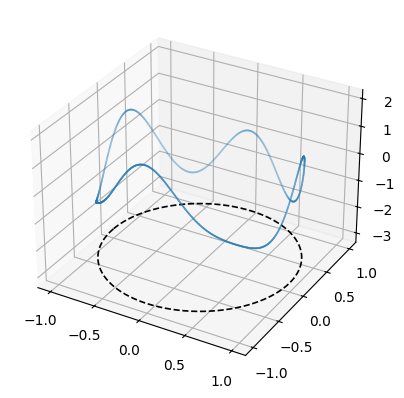

In [9]:
# Visualizing training data (in red) and groundtruth (in blue)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# train data
x_train = Xtr[:, 0].cpu().numpy()
y_train = Xtr[:, 1].cpu().numpy()
z_train = ytr.cpu().numpy().flatten()

# grid data
x_grid = Xgrid[:, 0].cpu().numpy()
y_grid = Xgrid[:, 1].cpu().numpy()
yte = ground_truth(Xgrid)
z_grid = yte.cpu().numpy().flatten()

# draw S^1 grid in black
x_s1 = Xgrid[:, 0].cpu().numpy()
y_s1 = Xgrid[:, 1].cpu().numpy()
# sort by angle so the line doesn’t zigzag
angles = np.arctan2(y_s1, x_s1)
order = np.argsort(angles)
z_base = np.full_like(order, fill_value=z_train.min() - 3)  # push circle slightly below labels
ax.plot(x_s1[order], y_s1[order], z_base, color="k", linewidth=1.2, linestyle='dashed', label='$S^1$')

# plot the grid groundtruth and train labels.
l1, = ax.scatter(x_grid , y_grid , z_grid, s = 0.1,label='groundtruth')
l2, = ax.scatter(x_train, y_train, z_train, color = 'red', s = 10, label='training data')

ax.set_xlabel('$x$')  # x-axis label
ax.set_ylabel('$y$')  # y-axis label
ax.set_zlabel('groundtruth')
ax.set_title('Visualizing the groundtruth')
ax.legend(['a','b'],[l1,l2])

plt.show()

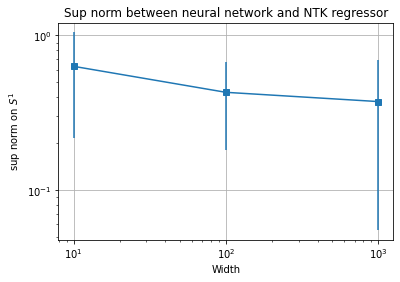

In [26]:
# Evolution of the sup norm between neural network regressor and NTK regressor w.r.t to width of the trained networks

plt.figure()
# plot mean of the network prediction minus NTK predictions ± std across seeds
plt.errorbar(xs, linf_krr_m, yerr=linf_krr_s, marker='s')  
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Width')
plt.ylabel(r'sup norm on $S^1$')
plt.title('Sup norm between neural network and NTK regressor')
plt.grid(True)
plt.show()

# Comment: Either does not decay or decays very slowly 

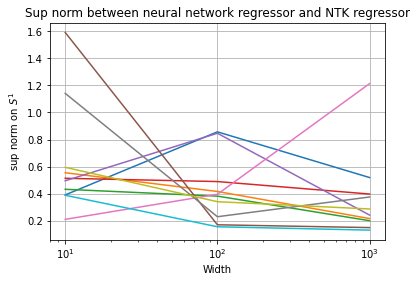

In [29]:
# Same plot as in the previous cell, but instead of mean ± std, we plot all trajectories

linf_krr_array = np.array([v for k, v in linf_krr.items()])

plt.figure()
plt.plot(xs, linf_krr_array)
plt.xscale('log')
plt.xlabel('Width')
plt.ylabel(r'sup norm on $S^1$')
plt.title('Sup norm between neural network regressor and NTK regressor')
plt.grid(True)

# Comment: We see that some runs do not even decay

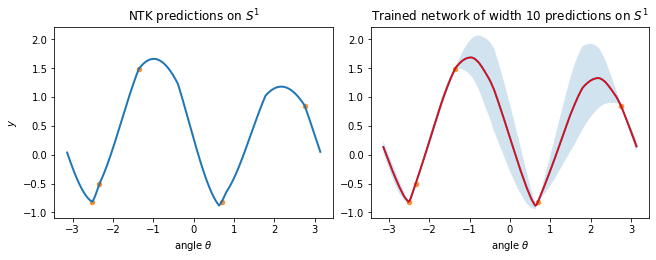

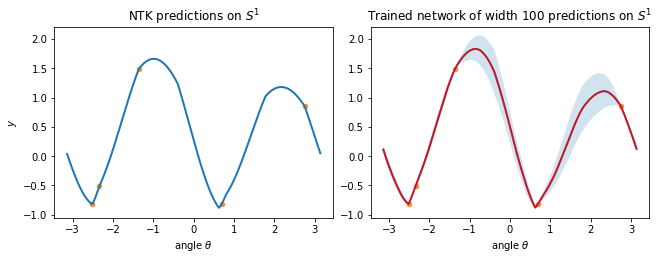

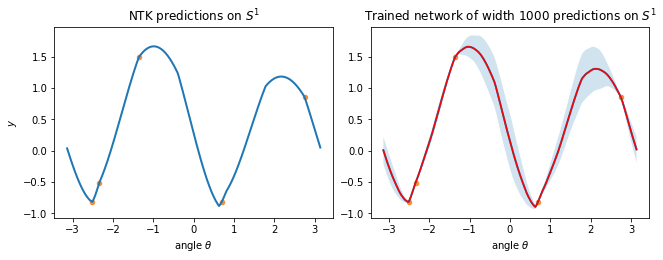

In [31]:
# Visualizing learned representation by network vs NTK with ±std for network predictions across seeds.
# two-panel plot: NTK vs trained net along angle θ; includes ±std for network predictions 
for i in range(len(WIDTHS)):  # loop over widths
  _ = plot_ntk_vs_net_by_angle(
      Xte=Xgrid, Xtr=Xtr, ytr=ytr,
      y_ntk_test_dict=y_ntk_grid_dict,
      y_net_test_dict=y_net_grid_dict,
      width=WIDTHS[i],
      aggregate="mean",  # average across seeds
      show_std_band=True    # set True if you run multiple seeds and want ±std
  )
  plt.show()
# Comment: seed = 8 gives similar shapes for NTK and trained network regressors 
# seed = 2 yields noticeably different results